In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import CoClustering
from surprise import Dataset, Reader
from surprise import accuracy

from sklearn.model_selection import train_test_split

from iads.recommandation.prediction import get_cosine_matrix, get_kernel_matrix

import warnings
warnings.filterwarnings('ignore')

/Users/mathilde/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# I. Chargement des données :

In [2]:
df_avis = pd.read_csv("../data/avis_clean.csv")
df_avis.head(2)

,comment,treated,date_published,title_review,author,note,title,title_id_jeu
0,"Lorsque le jeu est jeu, bon, réflexif, joli po...",True,2021,Voyages sur les ailes des papillons,Monsieur Guillaume,8.0,Mariposas,mariposas
1,Comment continuer après un mega hit ? Simpleme...,True,2020,le festival de Michoacan,morlockbob,7.0,Mariposas,mariposas


In [3]:
df_jeux = pd.read_csv("../data/details_desc.csv")
df_jeux.head(2)

,categories,titre,description,full_title,Note Finkel,Note rectifiée,Nombre d'avis rectifiés,Note,Nombre d'avis,_id,...,distributors,nb_players,age_required,duration,enfant,ado,adulte,solo,duo,multi
0,NaN,Marvel United,marvel united unis contre super vilain red sku...,Marvel United (2020),8.74,8.40,10.0,7.58,19.0,marvel-united,...,NaN,1-4,14-99,45.0,0,1,1,1,0,1
1,NaN,Mariposas,annee printemps million papillon monarque quit...,Mariposas (2020),7.68,7.29,17.0,7.39,33.0,mariposas,...,NaN,2-5,14-99,60.0,0,1,1,0,1,1


In [4]:
nb_desc_isna = len(df_jeux[df_jeux["description"].isna()])
nb_jeux = len(df_jeux)
print(nb_desc_isna, "descriptions manquantes sur", nb_jeux )
print(f"Soit {round((nb_desc_isna/nb_jeux)*100,3)}%")

1954 descriptions manquantes sur 16873
Soit 11.581%


In [5]:
desc_notna = df_jeux["description"].notna()
cat_notna = df_jeux["categories"].notna()

df_jeux_nona = df_jeux[desc_notna & cat_notna].reset_index(drop=True)

# II. Descriptions

Créer une matrice de similarité pondérée sur plusieurs caractéristiques des les jeux :

In [6]:
col_weights = {"'description'": 0.4,
            "'categories'":0.3,
            "['enfant','ado','adulte']":0.15,
            "['solo', 'duo', 'multi']":0.15} 

- Avec cosine : 

In [7]:
cosine_matrix = np.zeros((len(df_jeux_nona), len(df_jeux_nona)))

for col, weight in tqdm(col_weights.items()):
    similarity_matrix = get_cosine_matrix(df_jeux_nona, eval(col))
    cosine_matrix += similarity_matrix * weight

100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


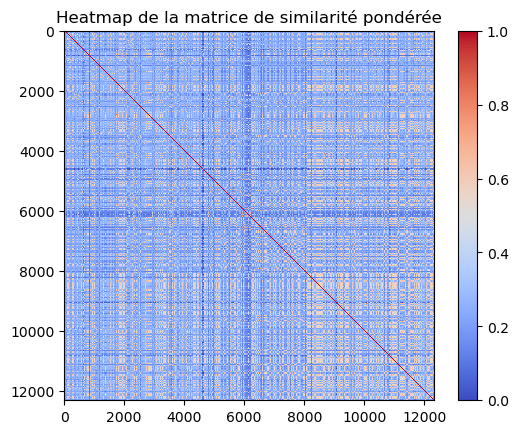

In [8]:
plt.imshow(cosine_matrix, cmap='coolwarm', interpolation='nearest')
plt.title('Heatmap de la matrice de similarité pondérée')
plt.colorbar()
plt.show()

- Kernel linear 

In [9]:
linear_matrix = np.zeros((len(df_jeux_nona), len(df_jeux_nona)))

for col, weight in tqdm(col_weights.items()):
    similarity_matrix = get_kernel_matrix(df_jeux_nona, eval(col), "linear")
    linear_matrix += similarity_matrix * weight

100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


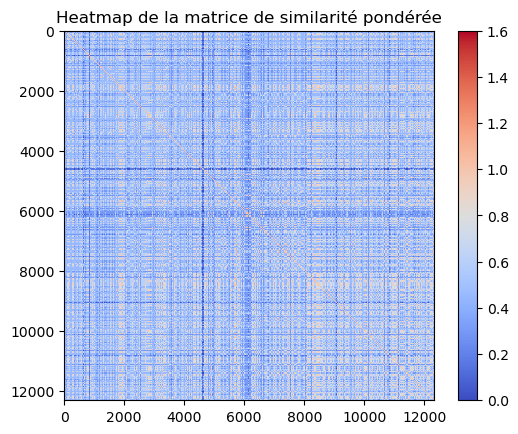

In [10]:
plt.imshow(linear_matrix, cmap='coolwarm', interpolation='nearest')
plt.title('Heatmap de la matrice de similarité pondérée')
plt.colorbar()
plt.show()

- rbf

In [11]:
rbf_matrix = np.zeros((len(df_jeux_nona), len(df_jeux_nona)))

for col, weight in tqdm(col_weights.items()):
    similarity_matrix = get_kernel_matrix(df_jeux_nona, eval(col), "rbf")
    rbf_matrix += similarity_matrix * weight

100%|██████████| 4/4 [00:15<00:00,  3.80s/it]


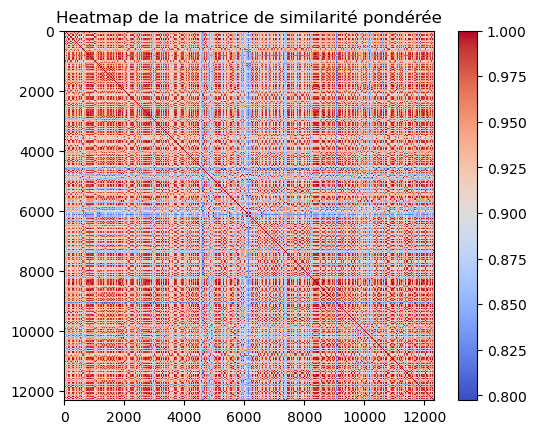

In [12]:
plt.imshow(rbf_matrix, cmap='coolwarm', interpolation='nearest')
plt.title('Heatmap de la matrice de similarité pondérée')
plt.colorbar()
plt.show()

# III. Recommandation

In [13]:
title = "Golden Horde"

In [14]:
df_jeux_nona[df_jeux_nona["titre"] == title][['titre', 'description','categories']]

,titre,description,categories
12308,Golden Horde,golden horde simulation simple rapide bataille...,guerre


In [15]:
def basic_recommand_games(matrix, df, title, nb_games=10):
    idx = df[df['titre'] == title].index[0]

    sim_scores = list(enumerate(matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = [i[0] for i in sim_scores if i[0] != idx][:nb_games]

    return df.iloc[sim_scores][['titre', 'description','categories']]

In [16]:
basic_recommand_games(cosine_matrix, df_jeux_nona, title)

,titre,description,categories
9132,Men of Iron - Volume I : The Rebirth of Infantry,men of iron interesse renouveau infanterie deb...,guerre
12282,Tigers in the Mist,simulation simple bataille ardenne,guerre
9655,The Battle for Cassino,simulation bataille nom,guerre
10342,Admiral,simulation bataille naval,guerre
7670,The Cossacks Are Coming !,simulation niveau brigade division permettre r...,guerre
6322,C.S.A America's Civil War 1861-1865,simulation guerre civil americain guerre seces...,guerre
9694,Devil's Horsemen,devil horsemen partie serie great battle of hi...,guerre
7764,Bataille de Fleurus,simulation bataille eponyme,guerre
7954,Austerlitz,wargame tactique permettre rejouer bataille au...,guerre
9742,"Borodino - Battle of the Moskova, 1812",borodino partie gameplayerserie editeur americ...,guerre


In [17]:
basic_recommand_games(linear_matrix, df_jeux_nona, title)

,titre,description,categories
9132,Men of Iron - Volume I : The Rebirth of Infantry,men of iron interesse renouveau infanterie deb...,guerre
12282,Tigers in the Mist,simulation simple bataille ardenne,guerre
9655,The Battle for Cassino,simulation bataille nom,guerre
10143,La Bataille de Valmy,simulation bataille nom,guerre
11440,Army Group South,simulation,guerre
10342,Admiral,simulation bataille naval,guerre
7670,The Cossacks Are Coming !,simulation niveau brigade division permettre r...,guerre
6322,C.S.A America's Civil War 1861-1865,simulation guerre civil americain guerre seces...,guerre
9694,Devil's Horsemen,devil horsemen partie serie great battle of hi...,guerre
7764,Bataille de Fleurus,simulation bataille eponyme,guerre


In [18]:
basic_recommand_games(rbf_matrix, df_jeux_nona, title)

,titre,description,categories
9132,Men of Iron - Volume I : The Rebirth of Infantry,men of iron interesse renouveau infanterie deb...,guerre
12282,Tigers in the Mist,simulation simple bataille ardenne,guerre
9655,The Battle for Cassino,simulation bataille nom,guerre
10342,Admiral,simulation bataille naval,guerre
7670,The Cossacks Are Coming !,simulation niveau brigade division permettre r...,guerre
6322,C.S.A America's Civil War 1861-1865,simulation guerre civil americain guerre seces...,guerre
9694,Devil's Horsemen,devil horsemen partie serie great battle of hi...,guerre
7764,Bataille de Fleurus,simulation bataille eponyme,guerre
7954,Austerlitz,wargame tactique permettre rejouer bataille au...,guerre
9742,"Borodino - Battle of the Moskova, 1812",borodino partie gameplayerserie editeur americ...,guerre


### Evaluation

In [19]:
def create_test_data(test_df, note_min):
    test_data = {}
    
    for row in test_df.itertuples():
        user_id = getattr(row, 'author')
        game_id = getattr(row, 'id')
        rating = getattr(row, 'Note')
        
        if rating >= note_min:
            if game_id not in test_data:
                test_data[game_id] = set()
            test_data[game_id].add(user_id)
    
    test_data = {game_id: [other_game_id for other_game_id in test_data if other_game_id != game_id and len(test_data[other_game_id] & test_data[game_id]) >= 1]
                for game_id in test_data if len(test_data[game_id]) >= 1}
    
    return test_data


In [20]:
#évalue la proportion de jeux recommandés qui sont effectivement pertinents pour l'utilisateur
#parmi les k premiers jeux recommandés.
def precision_at_k(similarity_matrix, k, test_data):
    precision = 0.0
    n_items = similarity_matrix.shape[0]
    
    for item in test_data:
        top_k_similarities = np.argsort(similarity_matrix[item])[::-1][:k]
        hits = 0
        for recommended_item in top_k_similarities:
            if recommended_item in test_data[item]:
                hits += 1
        precision += hits / k
    precision /= n_items
    
    return precision

In [21]:
def get_weighted_matrix(df, dict_weight, f) :
    cosine_matrix = np.zeros((len(df), len(df)))

    for col, weight in tqdm(dict_weight.items()):
        if f == get_kernel_matrix :
            similarity_matrix = f(df, eval(col),"rbf")
        else :
            similarity_matrix = f(df, eval(col))
        cosine_matrix += similarity_matrix * weight
        
    return cosine_matrix

In [22]:
_, test_data = train_test_split(df_jeux_nona, test_size=0.2)

In [23]:
len(test_data)

2463

In [24]:
note_min = df_avis["note"].mean()
note_min=5
note_min

5

In [25]:
#la base de test comprend tous les avis qui correspondent aux jeux du set test de df_jeux
#afin de savoir quels jeux ont été notés et par quels utilisateur
#les jeux avec une note supérieure à la note moyenne des avis seront considérés comme étant à recommander pour l'utilisateur
test_data = test_data.reset_index().rename(columns={'index': 'id'})
test_data = test_data.rename(columns={'titre': 'title'})
test_data = pd.merge(df_avis, test_data, on='title', how='inner')
test_data = create_test_data(test_data, note_min)

In [26]:
w1 = {"'description'": 0.4,
            "'categories'":0.3,
            "['enfant','ado','adulte']":0.15,
            "['solo', 'duo', 'multi']":0.15} 
w2 = {"'description'": 0.5,
            "'categories'":0.5} 
w3 = {"'description'": 1} 
w4 = {"'categories'": 1} 

col_weights=[w1, w2, w3, w4]


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


Précision de 0.0057342430149447884 pour les poids : {"'description'": 0.4, "'categories'": 0.3, "['enfant','ado','adulte']": 0.15, "['solo', 'duo', 'multi']": 0.15}


100%|██████████| 2/2 [00:06<00:00,  3.06s/it]


Précision de 0.005547433398310609 pour les poids : {"'description'": 0.5, "'categories'": 0.5}


100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Précision de 0.004686484730344406 pour les poids : {"'description'": 1}


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Précision de 0.0014538661468486017 pour les poids : {"'categories'": 1}


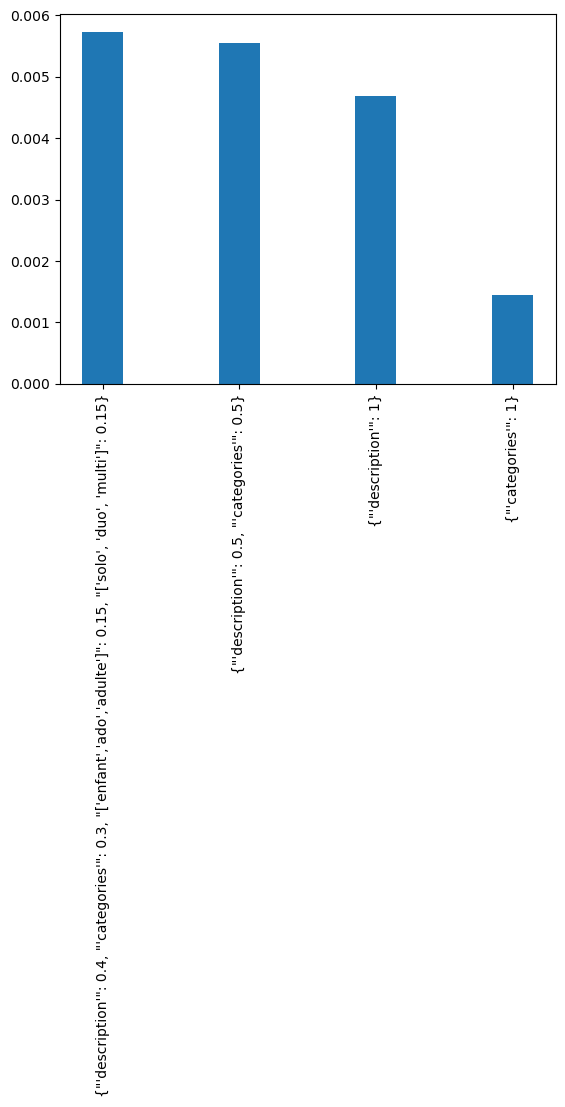

In [27]:
precision=[]
for w in col_weights :
    cosine_matrix = get_weighted_matrix(df_jeux_nona, w, get_cosine_matrix)
    precision.append(precision_at_k(cosine_matrix, 10, test_data))
    print(f"Précision de {precision[-1]} pour les poids : {w}")

plt.bar([str(w) for w in col_weights],precision, width=0.3)
plt.xticks(rotation='vertical')
plt.show()

100%|██████████| 4/4 [00:13<00:00,  3.29s/it]


Précision de 0.005588044184535434 pour les poids : {"'description'": 0.4, "'categories'": 0.3, "['enfant','ado','adulte']": 0.15, "['solo', 'duo', 'multi']": 0.15}


100%|██████████| 2/2 [00:07<00:00,  3.89s/it]


Précision de 0.005547433398310609 pour les poids : {"'description'": 0.5, "'categories'": 0.5}


100%|██████████| 1/1 [00:04<00:00,  4.27s/it]


Précision de 0.004686484730344406 pour les poids : {"'description'": 1}


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


Précision de 0.0014538661468486017 pour les poids : {"'categories'": 1}


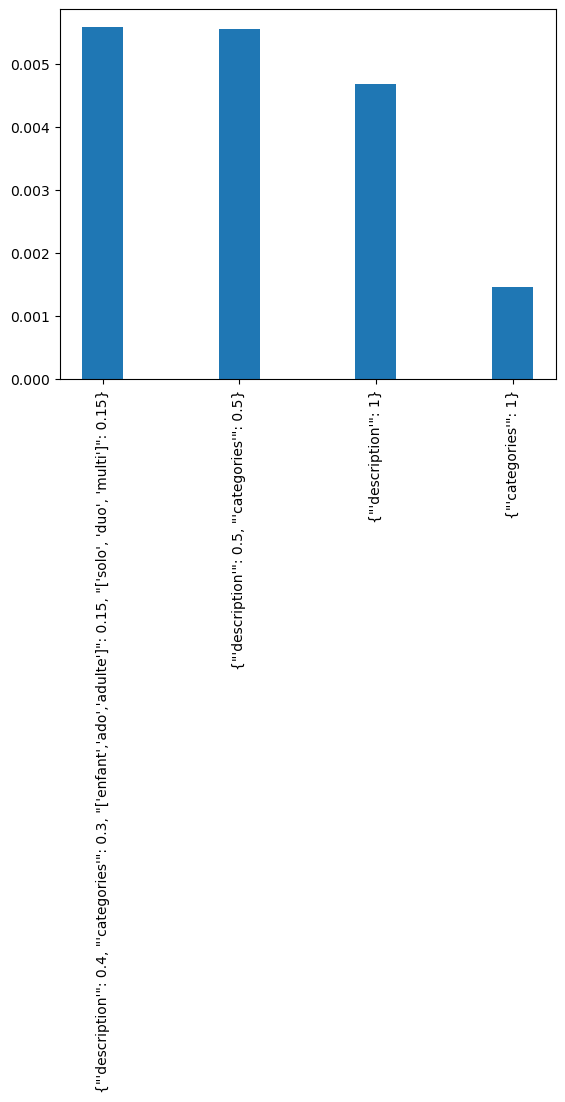

In [28]:
precision=[]
for w in col_weights :
    cosine_matrix = get_weighted_matrix(df_jeux_nona, w, get_kernel_matrix)
    precision.append(precision_at_k(cosine_matrix, 10, test_data))
    print(f"Précision de {precision[-1]} pour les poids : {w}")

plt.bar([str(w) for w in col_weights],precision, width=0.3)
plt.xticks(rotation='vertical')
plt.show()

# IV. Co-clustering

In [29]:
df_avis_filter = pd.read_csv("../data/avis_filter.csv")
df_avis_filter[["author", "title", "note"]].head(5)

,author,title,note
0,*FitzChevalerie*,"7 Wonders - Extension ""Cities""",8.0
1,*FitzChevalerie*,"7 Wonders - Extension ""Wonder Pack""",7.4
2,*FitzChevalerie*,A Few Acres of Snow,10.0
3,*FitzChevalerie*,Archipelago,10.0
4,*FitzChevalerie*,Archipelago : Solo Expansion,10.0


In [30]:
train_data, test_data = train_test_split(df_avis_filter[["author", "title", "note"]], test_size=0.2)

trainset = Dataset.load_from_df(train_data, Reader(rating_scale=(0, 10)))
trainset = trainset.build_full_trainset()
testset = Dataset.load_from_df(test_data, Reader(rating_scale=(0, 10)))
testset = testset.build_full_trainset()
testset = testset.build_testset()


In [31]:
train_rmse = []
train_mae = []
test_rmse = []
test_mae = []
n_cluster = [2000,1500,1000,500,250,100,50,25,10,5,2,1]
for n in n_cluster :
    n_cltr_u=int(len(np.unique(train_data["author"]))/n)
    n_cltr_i=int(len(np.unique(train_data["title"]))/n)
    algo = CoClustering(n_cltr_u=n_cltr_u, n_cltr_i=n_cltr_i, n_epochs=10)
    algo.fit(trainset)
    #predictions = algo.test(testset)
    train_predictions = algo.test(trainset.build_testset())
    test_predictions = algo.test(testset)
    train_rmse.append(accuracy.rmse(train_predictions,verbose=False))
    train_mae.append(accuracy.mae(train_predictions,verbose=False))
    test_rmse.append(accuracy.rmse(test_predictions,verbose=False))
    test_mae.append(accuracy.mae(test_predictions,verbose=False))


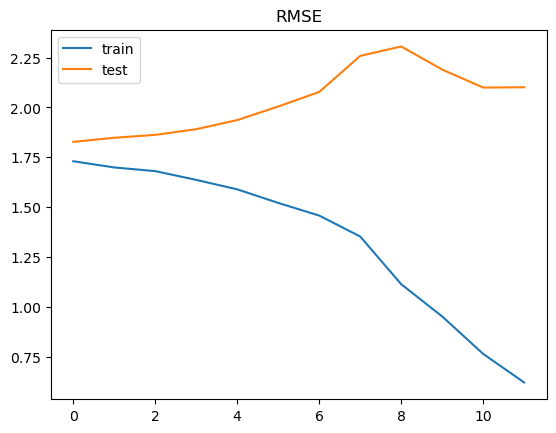

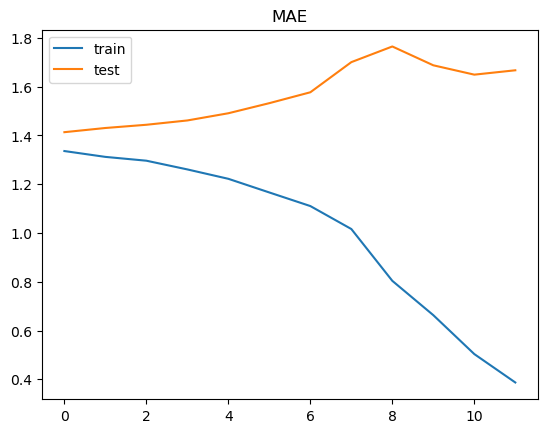

In [32]:
plt.plot(train_rmse, label="train")
plt.plot(test_rmse, label="test")
plt.title("RMSE")
plt.legend()
plt.show()
plt.plot(train_mae, label="train")
plt.plot(test_mae, label="test")
plt.title("MAE")
plt.legend()
plt.show()

In [33]:
print(f"Meilleur score rmse : {round(np.min(test_rmse),3)} et mae : {round(np.min(test_mae),3)}")
nb_cluster_u = int(len(np.unique(train_data["author"]))/n_cluster[np.argmin(test_rmse)])
nb_cluster_i = int(len(np.unique(train_data["title"]))/n_cluster[np.argmin(test_rmse)])
print(f"Donc le meilleur nombre de cluster est {nb_cluster_u} pour les utilisateur et {nb_cluster_i} pour les jeux")

Meilleur score rmse : 1.827 et mae : 1.413
Donc le meilleur nombre de cluster est 1 pour les utilisateur et 1 pour les jeux


In [34]:
trainset = Dataset.load_from_df(df_avis_filter[["author", "title", "note"]], Reader(rating_scale=(0, 10)))
trainset = trainset.build_full_trainset()
algo = CoClustering(n_cltr_u=nb_cluster_u, n_cltr_i=nb_cluster_i, n_epochs=10)
algo.fit(trainset)
predictions = algo.test(trainset.build_testset())

récupérer le meilleur modèle et afficher la heatmap

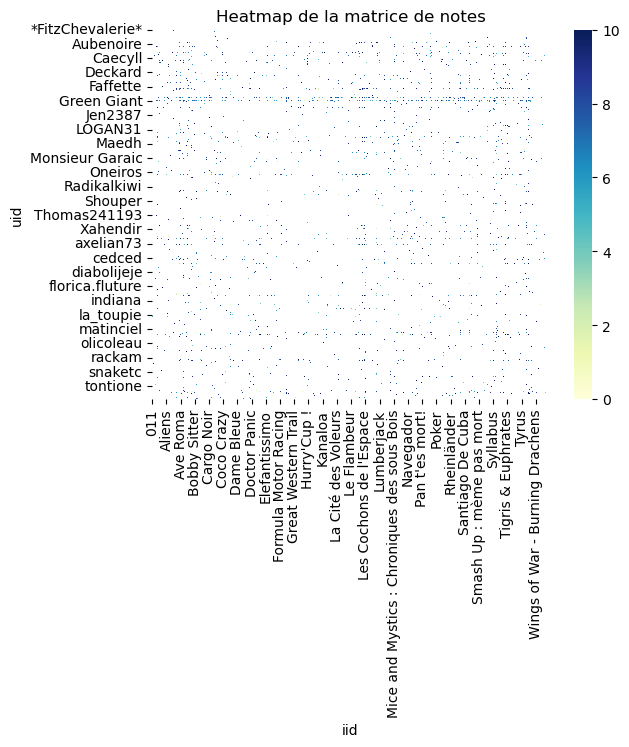

In [35]:
matrix = pd.DataFrame(predictions).pivot(index='uid', columns='iid', values='r_ui')

sns.heatmap(matrix, cmap='YlGnBu', fmt='g')
plt.title('Heatmap de la matrice de notes')
plt.show()

## Avec catégorie

In [36]:
#on ajoute la catégorie au dataframe à partir du dataframe de détail des jeux
reader = Reader(rating_scale=(0, 10))
game_categories = df_jeux_nona[['titre', 'categories']].set_index('titre').to_dict()['categories']
df_avis_filter['categories'] = df_avis_filter['title'].map(game_categories)


In [37]:
df_avis_filter[["author", "title", "note","categories"]].head(5)

,author,title,note,categories
0,*FitzChevalerie*,"7 Wonders - Extension ""Cities""",8.0,NaN
1,*FitzChevalerie*,"7 Wonders - Extension ""Wonder Pack""",7.4,NaN
2,*FitzChevalerie*,A Few Acres of Snow,10.0,guerre
3,*FitzChevalerie*,Archipelago,10.0,plateau
4,*FitzChevalerie*,Archipelago : Solo Expansion,10.0,placement


In [38]:
df_avis_filter.dropna(axis=0, inplace=True)

In [39]:
df_avis_filter[["author", "title", "note","categories"]].head(5)

,author,title,note,categories
2,*FitzChevalerie*,A Few Acres of Snow,10.0,guerre
3,*FitzChevalerie*,Archipelago,10.0,plateau
4,*FitzChevalerie*,Archipelago : Solo Expansion,10.0,placement
5,*FitzChevalerie*,Ginkgopolis,10.0,tete dessin combinaison casser
6,*FitzChevalerie*,Gosu 2 : Tactics,6.0,carte


In [40]:
len(df_avis_filter)

94651

In [41]:

reader = Reader(rating_scale=(0, 10))
trainset = Dataset.load_from_df(df_avis_filter[['author', 'title', 'note']], reader)

cocluster = CoClustering(n_cltr_u=10, n_cltr_i=10, random_state=42)

cocluster.fit(trainset.build_full_trainset(), item_data=df_avis_filter['categories'])

testset = trainset.build_full_trainset().build_anti_testset()
predictions = cocluster.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)


TypeError: fit() got an unexpected keyword argument 'item_data'

In [ ]:
# data = Dataset.load_from_df(df_avis_filter[["author","title","categories","note"]], Reader(rating_scale=(0, 10)), rating_scale=(0, 10))
# trainset = data.build_full_trainset()

# algo = CoClustering(n_cltr_u=3, n_cltr_i=3, n_epochs=10, use_categories=True)

# algo.fit(trainset)

# predictions = algo.test(trainset.build_testset())

# sns.heatmap(algo.biclusters_, cmap='YlGnBu', fmt='d')
# plt.title('Heatmap de la matrice de co-clustering')
# plt.show()

TypeError: load_from_df() got an unexpected keyword argument 'rating_scale'